# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Prerequisites" data-toc-modified-id="Prerequisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prerequisites</a></div><div class="lev1 toc-item"><a href="#Explore-training-data" data-toc-modified-id="Explore-training-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore training data</a></div><div class="lev2 toc-item"><a href="#Common-values" data-toc-modified-id="Common-values-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Common values</a></div><div class="lev2 toc-item"><a href="#Aggregate-by-traps" data-toc-modified-id="Aggregate-by-traps-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Aggregate by traps</a></div><div class="lev2 toc-item"><a href="#Lat/Lon" data-toc-modified-id="Lat/Lon-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Lat/Lon</a></div><div class="lev1 toc-item"><a href="#Explore-weather" data-toc-modified-id="Explore-weather-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explore weather</a></div><div class="lev1 toc-item"><a href="#Explore-spray" data-toc-modified-id="Explore-spray-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Explore spray</a></div><div class="lev1 toc-item"><a href="#Time-series-plots" data-toc-modified-id="Time-series-plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time series plots</a></div><div class="lev1 toc-item"><a href="#Try-other-ideas" data-toc-modified-id="Try-other-ideas-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Try other ideas</a></div>

# Prerequisites

Before using this notebook, make sure that the notebook `load_wnv_data.ipynb` has been run first. 

In [1]:
%matplotlib inline

/Users/shajek/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Establish database connection

In [3]:
%run db.ipynb

In [4]:
%config SQL.conn_name = 'conn'

Show available tables in the 'wnv' schema

In [5]:
%%read_sql
select * from information_schema.tables
where table_schema = 'wnv'

Query started at 02:34:13 PM EDT
Query executed in 0.00 m


,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,gpadmin,wnv,wnv_train,BASE TABLE,None,None,None,None,None,YES,NO,None
1,gpadmin,wnv,wnv_weather,BASE TABLE,None,None,None,None,None,YES,NO,None
2,gpadmin,wnv,wnv_spray,BASE TABLE,None,None,None,None,None,YES,NO,None
3,gpadmin,wnv,wnv_train_summary,BASE TABLE,None,None,None,None,None,YES,NO,None
4,gpadmin,wnv,wnv_weather_summary,BASE TABLE,None,None,None,None,None,YES,NO,None


# Explore training data

Explore contents of core training data (in `wnv_train` table)

Show Columns and their data types

In [6]:
%%read_sql

select table_schema, table_name, column_name, ordinal_position, 
    data_type
from information_schema.columns 
where table_schema = 'wnv'
    and table_name = 'wnv_train'
order by ordinal_position;

Query started at 02:34:27 PM EDT
Query executed in 0.00 m


,table_schema,table_name,column_name,ordinal_position,data_type
0,wnv,wnv_train,date,1,text
1,wnv,wnv_train,address,2,text
2,wnv,wnv_train,species,3,text
3,wnv,wnv_train,block,4,bigint
4,wnv,wnv_train,street,5,text
5,wnv,wnv_train,trap,6,text
6,wnv,wnv_train,addressnumberandstreet,7,text
7,wnv,wnv_train,latitude,8,double precision
8,wnv,wnv_train,longitude,9,double precision
9,wnv,wnv_train,addressaccuracy,10,bigint


In [7]:
%read_sql select * from wnv.wnv_train limit 3;

Query started at 02:34:29 PM EDT
Query executed in 0.00 m


,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,3,0
1,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,5,0
2,2007-06-05,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [11]:
%%read_sql
DROP TABLE IF EXISTS wnv.wnv_train_summary;
select madlib.summary('wnv.wnv_train', 'wnv.wnv_train_summary');

Query started at 04:58:17 PM EDT
Query executed in 0.00 m


Query started at 04:58:17 PM EDT
Query executed in 0.02 m


,summary
0,"(wnv.wnv_train_summary,12,1.36805510521)"


In [8]:
%%read_sql wnv_summary
select * from wnv.wnv_train_summary order by column_number;

Query started at 02:38:02 PM EDT
Query executed in 0.00 m


,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,date,1,text,10506,95,0,0.0,0.0,0.0,NaN,NaN,10.000000,10.000000,NaN,NaN,NaN,"[2007-08-01, 2007-08-15, 2013-08-01, 2007-08-2...","[551, 276, 186, 186, 186, 185, 184, 182, 182, ..."
1,None,None,address,2,text,10506,138,0,0.0,0.0,0.0,NaN,NaN,16.000000,89.000000,NaN,NaN,NaN,"[ORD Terminal 5, O'Hare International Airport,...","[750, 750, 542, 542, 314, 314, 185, 185, 183, ..."
2,None,None,species,3,text,10506,7,0,0.0,0.0,0.0,NaN,NaN,13.000000,22.000000,NaN,NaN,NaN,"[CULEX PIPIENS/RESTUANS, CULEX PIPIENS/RESTUAN...","[4752, 4752, 2740, 2740, 2699, 2699, 222, 222,..."
3,None,None,block,4,int8,10506,64,0,NaN,0.0,NaN,35.687797,592.409707,10.000000,98.000000,12.000000,33.000000,52.000000,"[10, 10, 11, 11, 12, 12, 22, 22, 13, 13]","[1722, 1722, 736, 736, 605, 605, 500, 500, 345..."
4,None,None,street,5,text,10506,128,0,0.0,0.0,0.0,NaN,NaN,8.000000,30.000000,NaN,NaN,NaN,"[ W OHARE AIRPORT, W OHARE AIRPORT, S DOTY A...","[750, 750, 542, 542, 347, 347, 266, 266, 216, ..."
5,None,None,trap,6,text,10506,136,0,0.0,0.0,0.0,NaN,NaN,4.000000,5.000000,NaN,NaN,NaN,"[T900, T900, T115, T115, T138, T138, T002, T00...","[750, 750, 542, 542, 314, 314, 185, 185, 183, ..."
6,None,None,addressnumberandstreet,7,text,10506,138,0,0.0,0.0,0.0,NaN,NaN,26.000000,48.000000,NaN,NaN,NaN,"[1000 W OHARE AIRPORT, Chicago, IL, 1000 W O...","[750, 750, 542, 542, 314, 314, 185, 185, 183, ..."
7,None,None,latitude,8,float8,10506,138,0,NaN,0.0,NaN,41.841139,0.012711,41.644612,42.017430,41.732984,41.846283,41.954690,"[41.974689, 41.974689, 41.673408, 41.673408, 4...","[750, 750, 542, 542, 314, 314, 185, 185, 183, ..."
8,None,None,longitude,9,float8,10506,138,0,NaN,0.0,NaN,-87.699908,0.009315,-87.930995,-87.531635,-87.760070,-87.694991,-87.627796,"[-87.890615, -87.890615, -87.599862, -87.59986...","[750, 750, 542, 542, 314, 314, 185, 185, 183, ..."
9,None,None,addressaccuracy,10,int8,10506,4,0,NaN,0.0,NaN,7.819532,2.110979,3.000000,9.000000,8.000000,8.000000,9.000000,"[8, 8, 9, 9, 5, 5, 3, 3]","[4628, 4628, 3980, 3980, 1807, 1807, 91, 91]"


In [13]:
wnv_summary.target_column

0                       date
1                    address
2                    species
3                      block
4                     street
5                       trap
6     addressnumberandstreet
7                   latitude
8                  longitude
9            addressaccuracy
10              nummosquitos
11                wnvpresent
Name: target_column, dtype: object

In [14]:
', '.join(wnv_summary.target_column)

'date, address, species, block, street, trap, addressnumberandstreet, latitude, longitude, addressaccuracy, nummosquitos, wnvpresent'

## Common values

In [15]:
%%read_sql
select species, count(*) n 
from wnv.wnv_train 
group by species
order by n desc;

Query started at 04:58:52 PM EDT
Query executed in 0.00 m


,species,n
0,CULEX PIPIENS/RESTUANS,4752
1,CULEX RESTUANS,2740
2,CULEX PIPIENS,2699
3,CULEX TERRITANS,222
4,CULEX SALINARIUS,86
5,CULEX TARSALIS,6
6,CULEX ERRATICUS,1


In [16]:
%%read_sql
select addressaccuracy, count(*) n 
from wnv.wnv_train 
group by addressaccuracy
order by addressaccuracy;

Query started at 04:58:52 PM EDT
Query executed in 0.00 m


,addressaccuracy,n
0,3,91
1,5,1807
2,8,4628
3,9,3980


What does `addressaccuracy` mean?

In [17]:
%%read_sql
select block, count(*) n 
from wnv.wnv_train 
group by block
order by block;

Query started at 04:58:56 PM EDT
Query executed in 0.00 m


,block,n
0,10,1722
1,11,736
2,12,605
3,13,345
4,14,97
5,15,90
6,17,305
7,18,43
8,20,25
9,21,49


In [18]:
%%read_sql
select trap, count(*) n 
from wnv.wnv_train 
group by trap
order by n desc;

Query started at 04:59:01 PM EDT
Query executed in 0.00 m


,trap,n
0,T900,750
1,T115,542
2,T138,314
3,T002,185
4,T135,183
5,T054,163
6,T128,160
7,T151,156
8,T212,152
9,T090,151


In [19]:
%%read_sql
select wnvpresent, count(*) n 
from wnv.wnv_train 
group by wnvpresent
order by wnvpresent;

Query started at 04:59:02 PM EDT
Query executed in 0.00 m


,wnvpresent,n
0,0,9955
1,1,551


In [9]:
%%read_sql nmosq
select nummosquitos, count(*) n 
from wnv.wnv_train 
group by nummosquitos
order by nummosquitos;

Query started at 02:38:22 PM EDT
Query executed in 0.00 m


,nummosquitos,n
0,1,2307
1,2,1300
2,3,896
3,4,593
4,5,489
5,6,398
6,7,326
7,8,244
8,9,237
9,10,206


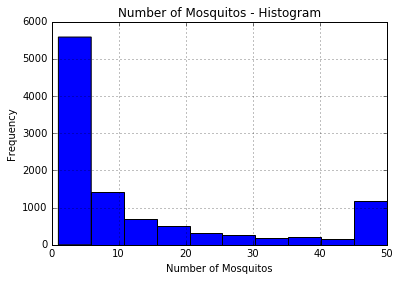

In [21]:
nmosq.nummosquitos.hist(weights=nmosq.n)
plt.title('Number of Mosquitos - Histogram')
plt.xlabel('Number of Mosquitos')
plt.ylabel('Frequency')

## Aggregate by traps

Does "trap" uniquely identify an address, etc?

In [17]:
%%read_sql
drop table if exists traps_group_all;
create temporary table traps_group_all
as (
    select
        "date", 
        address, 
        species, 
        block, 
        street, 
        trap, 
        addressnumberandstreet, 
        latitude, longitude,
        sum(nummosquitos) as nummosquitos,
        sum(wnvpresent) as wnvpresent,
        count(*) as n_samples
    from wnv.wnv_train
    group by 
        "date", 
        address, 
        species, 
        block, 
        street, 
        trap, 
        addressnumberandstreet, 
        latitude, longitude
)

Query started at 03:19:13 PM EDT
Query executed in 0.00 m


Query started at 03:19:13 PM EDT
Query executed in 0.01 m


In [18]:
%read_sql select count(*) from traps_group_all;

Query started at 03:19:20 PM EDT
Query executed in 0.00 m


,count
0,8475


In [78]:
%%read_sql -d trap_samples
select n_samples from traps_group_all;

Query started at 04:11:10 PM EDT
Query executed in 0.00 m


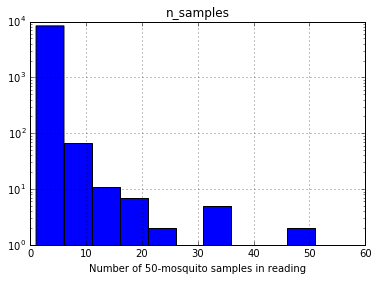

In [25]:
trap_samples.hist()
plt.gca().set_yscale('log')
plt.xlabel('Number of 50-mosquito samples in reading')

In [26]:
%%read_sql
drop table if exists traps_collapse_species;
create temporary table traps_collapse_species
as (
    select
        "date", 
        address, 
        block, 
        street, 
        trap, 
        addressnumberandstreet, 
        latitude, longitude,
        sum(nummosquitos) as nummosquitos,
        sum(wnvpresent) as wnvpresent,
        sum(n_samples) as n_samples,
        count(*) n_species,
        count(distinct species) as n_distinct_species
    from traps_group_all
    group by 
        "date", 
        address, 
        block, 
        street, 
        trap, 
        addressnumberandstreet, 
        latitude, longitude
)

Query started at 03:53:05 PM EDT
Query executed in 0.00 m


Query started at 03:53:05 PM EDT
Query executed in 0.01 m


In [27]:
%%read_sql
select count(*) from traps_collapse_species;

Query started at 03:53:10 PM EDT
Query executed in 0.00 m


,count
0,4616


In [26]:
%%read_sql
select n_species, n_distinct_species, count(*) as freq
from traps_collapse_species
group by n_species, n_distinct_species
;

Query started at 05:00:58 PM EDT
Query executed in 0.00 m


,n_species,n_distinct_species,freq
0,4,4,75
1,1,1,1710
2,2,2,2038
3,3,3,788
4,5,5,5


In [38]:
%%read_sql
select "date", trap, count(*) as n
from traps_collapse_species
group by "date", trap
order by n desc
limit 5;

Query started at 02:18:19 PM EDT
Query executed in 0.00 m


,date,trap,n
0,2007-08-22,T107,1
1,2009-08-13,T066,1
2,2013-09-06,T077,1
3,2009-06-19,T054,1
4,2013-07-19,T094B,1


So when you group by all the fields except mosquito counts and species, then you get only a single record per date/trap combination. 

<mark style="background-color: yellow">Next steps:</mark>  
1. Group by date, trap, and species.  
2. Aggregate mosquito counts.  
3. Pivot species.  

In [ ]:
## UNFINISHED
## Perhaps abandon sugarlib/pdltools examples, because not currently installed on the cluster
%%read_sql
select sugarlib.sugar($$
    create temporary table pivot_species as
        select 
            "date", trap,
            sugarlib.pivot(species, group)
        from traps_group_all
        group by "date", trap
$$);

## Lat/Lon

In [11]:
%%read_sql latlon_full
select latitude, longitude, count(*) n
from wnv.wnv_train
group by latitude, longitude
;

Query started at 02:55:41 PM EDT
Query executed in 0.00 m


,latitude,longitude,n
0,41.953067,-87.776792,18
1,41.673408,-87.599862,542
2,41.944869,-87.832763,133
3,41.862292,-87.648860,32
4,41.771660,-87.703047,116
5,42.009876,-87.807277,50
6,41.883284,-87.705085,15
7,41.747850,-87.702716,13
8,41.737052,-87.543067,21
9,41.907645,-87.760886,41


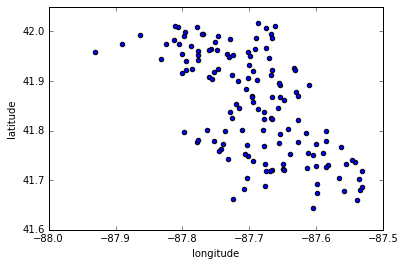

In [12]:
latlon_full.plot(x='longitude', y='latitude', kind='scatter')

In [32]:
map(hex, (191, 0, 191))

['0xbf', '0x0', '0xbf']

In [35]:
16*16

256

In [36]:
map(hex, (220, 0, 220))

['0xdc', '0x0', '0xdc']

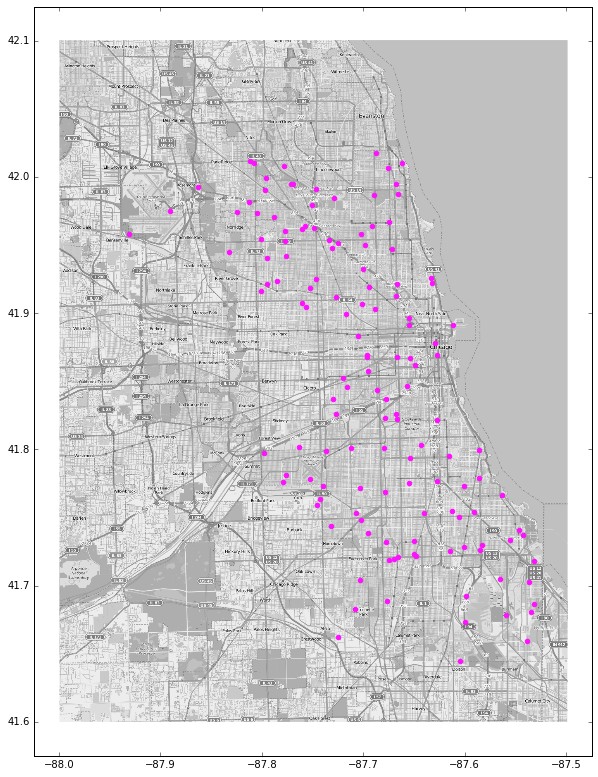

In [42]:
mapdata = np.loadtxt("../input/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

plt.scatter(latlon_full['longitude'], latlon_full['latitude'], marker='o', color='#ff10ff')

# Explore weather

TODO:

* explore as time series
* aggregate (in-database) by day to plot time series (as if it were a large data set)
* 

In [30]:
%%read_sql

select table_schema, table_name, column_name, ordinal_position, 
    data_type
from information_schema.columns 
where table_schema = 'wnv'
    and table_name = 'wnv_weather'
order by ordinal_position;

Query started at 05:36:41 PM EDT
Query executed in 0.00 m


,table_schema,table_name,column_name,ordinal_position,data_type
0,wnv,wnv_weather,station,1,bigint
1,wnv,wnv_weather,date,2,text
2,wnv,wnv_weather,tmax,3,bigint
3,wnv,wnv_weather,tmin,4,bigint
4,wnv,wnv_weather,tavg,5,text
5,wnv,wnv_weather,depart,6,text
6,wnv,wnv_weather,dewpoint,7,bigint
7,wnv,wnv_weather,wetbulb,8,text
8,wnv,wnv_weather,heat,9,text
9,wnv,wnv_weather,cool,10,text


In [31]:
%read_sql select * from wnv.wnv_weather limit 3;

Query started at 05:36:47 PM EDT
Query executed in 0.00 m


,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [32]:
%%read_sql
DROP TABLE IF EXISTS wnv.wnv_weather_summary;
select madlib.summary('wnv.wnv_weather', 'wnv.wnv_weather_summary');

Query started at 05:36:50 PM EDT
Query executed in 0.00 m


Query started at 05:36:50 PM EDT
Query executed in 0.01 m


,summary
0,"(wnv.wnv_weather_summary,22,0.452213048935)"


In [44]:
%%read_sql weather_summary
select * from wnv.wnv_weather_summary order by column_number;

Query started at 05:45:32 PM EDT
Query executed in 0.00 m


,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,station,1,int8,2944,2,0,NaN,0.0,NaN,1.500000,0.250085,1.0,2.0,1.0,1.5,2.0,"[2, 1]","[1472, 1472]"
1,None,None,date,2,text,2944,1472,0,0.0,0.0,0.000000,NaN,NaN,10.0,10.0,NaN,NaN,NaN,"[2010-09-15, 2011-05-11, 2012-08-17, 2012-09-0...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]"
2,None,None,tmax,3,int8,2944,63,0,NaN,0.0,NaN,76.166101,131.376751,41.0,104.0,69.0,78.0,85.0,"[84, 84, 79, 79, 82, 82, 81, 81, 83, 83]","[128, 128, 121, 121, 118, 118, 117, 117, 109, ..."
3,None,None,tmin,4,int8,2944,54,0,NaN,0.0,NaN,57.810462,107.784654,29.0,83.0,50.0,59.0,66.0,"[63, 63, 65, 65, 60, 61, 61, 62, 62, 57]","[121, 121, 111, 111, 109, 106, 106, 105, 105, ..."
4,None,None,tavg,5,text,2944,60,0,0.0,0.0,0.000000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,"[73, 73, 70, 77, 77, 70, 75, 75, 71, 74]","[138, 138, 117, 117, 117, 117, 110, 110, 109, ..."
5,None,None,depart,6,text,2944,42,0,0.0,0.0,0.000000,NaN,NaN,1.0,3.0,NaN,NaN,NaN,"[M, 2, -1, -2, 5, 7, 1, 3, 0, -3]","[1472, 93, 84, 80, 77, 76, 76, 75, 74, 72]"
6,None,None,dewpoint,7,int8,2944,54,0,NaN,0.0,NaN,53.457880,113.959489,22.0,75.0,46.0,54.0,62.0,"[59, 59, 54, 54, 55, 55, 60, 60, 61, 61]","[128, 128, 125, 125, 114, 114, 113, 113, 110, ..."
7,None,None,wetbulb,8,text,2944,48,0,0.0,0.0,0.000000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,"[63, 63, 65, 65, 59, 59, 61, 61, 64, 64]","[135, 135, 131, 131, 129, 129, 123, 123, 121, ..."
8,None,None,heat,9,text,2944,31,0,0.0,0.0,0.000000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,"[0, 0, 4, 4, 1, 1, 2, 2, 8, 8]","[1870, 1870, 88, 88, 86, 86, 81, 81, 67, 67]"
9,None,None,cool,10,text,2944,31,0,0.0,0.0,0.000000,NaN,NaN,1.0,2.0,NaN,NaN,NaN,"[ 0, 0, 8, 8, 12, 5, 5, 12, 10, 10]","[1147, 1147, 138, 138, 117, 117, 117, 117, 110..."


<mark>sunrise</mark>, <mark>sunset</mark>, and <mark>codesum</mark> all have blank values

In [120]:
weather_distinct_vals = ', '.join([
    'array_agg(distinct {0}) as {0}'.format(_c) for _c in weather_summary['target_column']
    if _c != 'date'
])
weather_distinct_vals

'array_agg(distinct station) as station, array_agg(distinct tmax) as tmax, array_agg(distinct tmin) as tmin, array_agg(distinct tavg) as tavg, array_agg(distinct depart) as depart, array_agg(distinct dewpoint) as dewpoint, array_agg(distinct wetbulb) as wetbulb, array_agg(distinct heat) as heat, array_agg(distinct cool) as cool, array_agg(distinct sunrise) as sunrise, array_agg(distinct sunset) as sunset, array_agg(distinct codesum) as codesum, array_agg(distinct depth) as depth, array_agg(distinct water1) as water1, array_agg(distinct snowfall) as snowfall, array_agg(distinct preciptotal) as preciptotal, array_agg(distinct stnpressure) as stnpressure, array_agg(distinct sealevel) as sealevel, array_agg(distinct resultspeed) as resultspeed, array_agg(distinct resultdir) as resultdir, array_agg(distinct avgspeed) as avgspeed'

In [121]:
%%read_sql weather_distinct_df
select {weather_distinct_vals}
from wnv.wnv_weather

Query started at 04:41:40 PM EDT
Query executed in 0.00 m


,station,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,"[1, 2]","[41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5...","[29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...","[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 4...","[ 0, 1, -1, 10, -10, 11, -11, 12, -12, 13, -1...","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...","[ 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1...","[-, 0416, 0417, 0418, 0419, 0420, 0421, 0422, ...",...,"[ , BCFG BR, BR, BR HZ, BR HZ FU, BR HZ VCFG, ...","[0, M]",[M],"[0.0, 0.1, M, T]","[0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.0...","[28.55, 28.59, 28.63, 28.67, 28.69, 28.71, 28....","[29.23, 29.25, 29.34, 29.43, 29.44, 29.45, 29....","[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10...."


In [125]:
%%read_sql -d tavg
select 
    extract(year from "date"::date)::int as "year",
    extract(month from "date"::date)::int as "month",
    (case when tavg = 'M' then NULL else tavg end)::float as tavg, count(*) as n
from wnv.wnv_weather
group by "year", "month", tavg
;

Query started at 04:43:34 PM EDT
Query executed in 0.00 m


In [126]:
tavg.head()

,year,month,tavg,n
0,2008,6,62.0,1
1,2013,8,74.0,3
2,2010,9,56.0,4
3,2014,6,73.0,2
4,2013,5,46.0,2


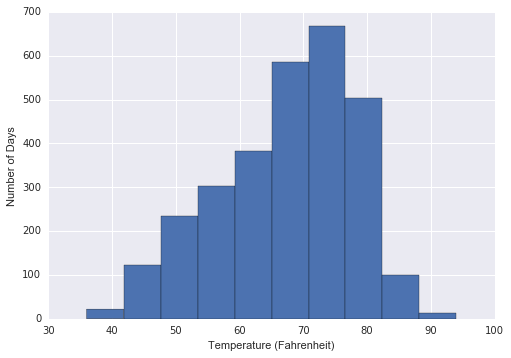

In [202]:
plt.hist(tavg.dropna().tavg, weights=tavg.dropna().n)
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Number of Days')

In [148]:
tavg_month = tavg.dropna().groupby(['month', 'tavg']).agg({'n': sum})

In [155]:
tavg_month.reset_index(level=-1, inplace=True)

In [156]:
tavg_month.head()

,tavg,n
month,,
5,42.0,1
5,43.0,1
5,44.0,3
5,45.0,4
5,46.0,7


In [152]:
tavg_month.index.levels[0]

Int64Index([5, 6, 7, 8, 9, 10], dtype='int64', name=u'month')

In [158]:
tavg_month.xs(5).head()

,tavg,n
month,,
5,42.0,1
5,43.0,1
5,44.0,3
5,45.0,4
5,46.0,7


In [160]:
tavg_month.index

Int64Index([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
            ...
            10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
           dtype='int64', name=u'month', length=224)

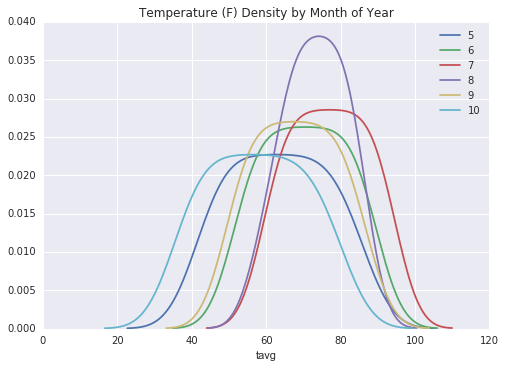

In [203]:
for i in sorted(set(tavg_month.index))[:]:
    sns.distplot(
        tavg_month.xs(i).tavg, 
        bins=10,
        hist=False, 
        hist_kws=dict(weights=tavg_month.xs(i).n), 
        label=str(i)
    )
plt.legend()
plt.title('Temperature (F) Density by Month of Year')

In [206]:
%%read_sql -d preciptotal
select 
    extract(month from "date"::date)::int as "month",
    (case 
         when trim(preciptotal) = 'M' then NULL 
         when trim(preciptotal) = 'T' then '0.001'
         else trim(preciptotal) 
     end)::float as preciptotal, count(*) as n
from wnv.wnv_weather
group by "month", preciptotal
;

Query started at 05:57:23 PM EDT
Query executed in 0.00 m


In [207]:
preciptotal.preciptotal.isnull().value_counts()

False    448
True       1
Name: preciptotal, dtype: int64

In [208]:
preciptotal.dropna(inplace=True)

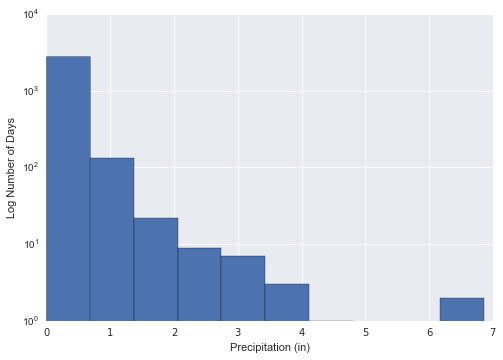

In [211]:
plt.hist(preciptotal.preciptotal, weights=preciptotal.n)
plt.xlabel('Precipitation (in)')
plt.ylabel('Log Number of Days')
plt.gca().set_yscale('log')

# Explore spray

In [58]:
%%read_sql

select table_schema, table_name, column_name, ordinal_position, 
    data_type
from information_schema.columns 
where table_schema = 'wnv'
    and table_name = 'wnv_spray'
order by ordinal_position;

Query started at 04:17:16 PM EDT
Query executed in 0.00 m


,table_schema,table_name,column_name,ordinal_position,data_type
0,wnv,wnv_spray,date,1,text
1,wnv,wnv_spray,time,2,text
2,wnv,wnv_spray,latitude,3,double precision
3,wnv,wnv_spray,longitude,4,double precision


In [59]:
%read_sql select * from wnv.wnv_spray limit 3;

Query started at 04:17:40 PM EDT
Query executed in 0.00 m


,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157


In [60]:
%%read_sql
DROP TABLE IF EXISTS wnv.wnv_spray_summary;
select madlib.summary('wnv.wnv_spray', 'wnv.wnv_spray_summary');

Query started at 04:18:18 PM EDT
Query executed in 0.00 m


Query started at 04:18:18 PM EDT
Query executed in 0.02 m


,summary
0,"(wnv.wnv_spray_summary,4,1.0604801178)"


In [61]:
%%read_sql spray_summary
select * from wnv.wnv_spray_summary order by column_number;

Query started at 04:21:27 PM EDT
Query executed in 0.00 m


,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,date,1,text,14835,10,0,0.0,0.000000,0.0,NaN,NaN,10.000000,10.000000,NaN,NaN,NaN,"[2013-08-15, 2013-08-29, 2013-07-17, 2011-09-0...","[2668, 2302, 2202, 2114, 1607, 1587, 1195, 924..."
1,None,None,"""time""",2,text,14835,8583,584,0.0,0.039366,0.0,NaN,NaN,10.000000,11.000000,NaN,NaN,NaN,"[7:44:32 PM, 9:49:45 PM, 8:27:31 PM, 8:09:26 P...","[550, 20, 16, 16, 14, 14, 14, 14, 13, 13]"
2,None,None,latitude,3,float8,14835,12871,0,NaN,0.000000,NaN,41.904828,0.010895,41.713925,42.395983,41.785001,41.940075,41.980978,"[41.98646, 41.7797466666667, 41.9953963549253,...","[550, 17, 17, 17, 15, 14, 13, 13, 13, 13]"
3,None,None,longitude,4,float8,14835,13296,0,NaN,0.000000,NaN,-87.736690,0.004528,-88.096468,-87.586727,-87.794225,-87.727853,-87.694108,"[-87.794225, -87.8145016666667, -87.8118766666...","[550, 16, 15, 14, 14, 14, 14, 13, 13, 13]"


<span style="color: red">time</span> has ~ 7% missing values

# Time series plots

* Agg by day
* group by feature (e.g. species) and WNV plot (categorical)
* box plot of temps broken down by WNV (numeric)
* scatter-matrix? 


# Try other ideas

**Provide prompt ideas**

In [5]:
%%read_sql
select 1;

Query started at 03:35:30 PM EDT
Query executed in 0.00 m


,?column?
0,1


In [6]:
%%read_sql
select madlib.summary();

Query started at 03:35:33 PM EDT
Query executed in 0.00 m


,summary
0,\n 'summary' is a generic function ...


In [8]:
%%read_sql _x
select madlib.create_indicator_variables();

Query started at 03:37:15 PM EDT
Query executed in 0.00 m


,create_indicator_variables
0,\n--------------------------------------------...


In [10]:
print _x.iloc[0, 0]


-----------------------------------------------------------------------
                            SUMMARY
-----------------------------------------------------------------------
Provide functionality to create indicator variables from categorical variables
to be used by regression methods. Categorical variables require special
attention in regression analysis because, unlike dichotomous or continuous
variables, they cannot by entered into the regression equation just as they are.
For example, if you have a variable called race that is coded 1 = Hispanic, 2 =
Asian 3 = Black 4 = White, then entering race in your regression will look at
the linear effect of race, which is probably not what you intended. Instead,
categorical variables like this need to be recoded into a series of indicator
variables which can then be entered into the regression model.

For more details on function usage:
    SELECT madlib.create_indicator_variables('usage')
            
